In [38]:
import pandas as pd
import matplotlib.pyplot as mat
from scipy.signal import savgol_filter
from analyze import *

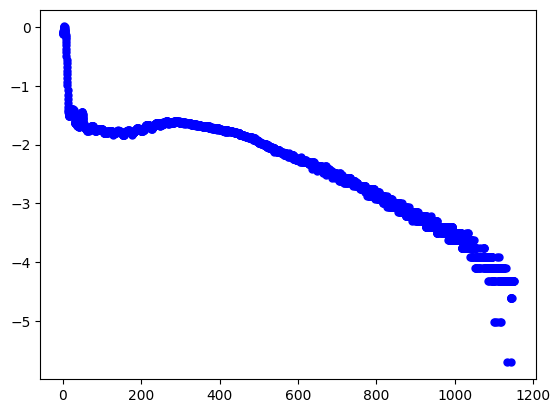

In [40]:
data = pd.read_csv("/Users/ypm/Desktop/DoS/analysis_results.csv")
# data = data[(data['Times'] >= 200) & (data['Times'] <= 500)]
mat.plot(data['Times'], data['Width'], 'bo', markersize=5)
mat.show()

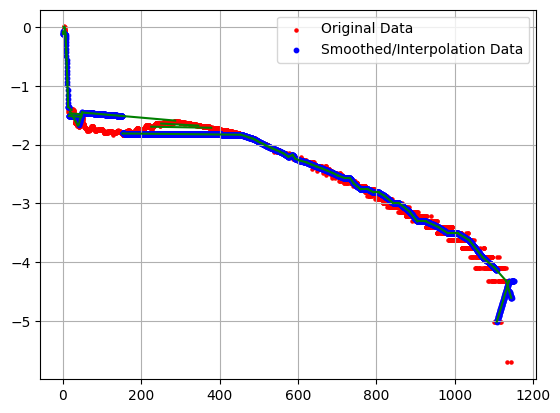

,Times,Width
0,0.333444,-0.072571
1,0.666889,-0.090654
2,1.083695,-0.101725
3,1.500500,-0.112795
4,1.500500,-0.112795
...,...,...
3443,1148.382794,-4.317488
3444,1148.716239,-4.317488
3445,1149.049683,-4.317488
3446,1149.383128,-4.317488


In [41]:
def linspaceSmoother(df):
    processed_df = df.copy()
    df['Diff'] = df['Width'].diff()
    step_centers = df.groupby('Width')['Times'].median().tolist()

    mat.scatter(df['Times'], df['Width'], label='Original Data', s=5, color="red")
    # mat.vlines(step_centers, ymin=df['Width'].min(), ymax=df['Width'].max(), color='grey', label='Step Centers')

    step_widths = []
    step_centers = step_centers[::-1]
    for center in step_centers:
        width = df[df['Times'] == center]['Width'].values
        if len(width) == 0:
            nearest_width = df.iloc[(df['Times'] - center).abs().argsort()[:1]]['Width'].values
            if len(nearest_width) > 0:
                step_widths.append(nearest_width[0])
        else:
            step_widths.append(width[0])

    for i in range(len(step_widths) - 1):
        df_for_x = df[(df['Times'] >= step_centers[i]) & (df['Times'] <= step_centers[i + 1])]
        count_x = len(df_for_x)

        x_vals = np.linspace(step_centers[i], step_centers[i + 1], num=count_x)
        y_vals = np.linspace(step_widths[i], step_widths[i + 1], num=count_x)

        processed_df.loc[df_for_x.index, 'Times'] = x_vals
        processed_df.loc[df_for_x.index, 'Width'] = y_vals

        mat.plot(x_vals, y_vals, color='green')

    mat.scatter(processed_df['Times'], processed_df['Width'], label='Smoothed/Interpolation Data', s=10, color="blue")

    mat.legend()
    mat.grid()
    mat.show()

    processed_df = processed_df[["Times", "Width"]]
    processed_df = processed_df.dropna()
    return  processed_df

linspaceSmoother(data)

In [42]:
lst = [-0.030833597713873333, -0.009288768641764502, -0.00674562609903124, -0.005553698090386595, -0.005322126609342771, -0.005579211802870715, -0.005307454081548802, -0.006196692178112779, -0.007463429999292361, -0.022300585180739217]

def findSlope(lst):
    slope = []
    for i in range(len(lst) - 1):
        ratio = lst[i] / lst[i+1]
        print(f"{lst[i]}/{lst[i+1]} = {ratio}")
        if 1.2 >= ratio >= 0.8:
            slope.append(lst[i])
            slope.append(lst[i+1])
    return sum(slope) / len(slope)
        
findSlope(lst)

-0.030833597713873333/-0.009288768641764502 = 3.3194494236015504
-0.009288768641764502/-0.00674562609903124 = 1.3770061526384467
-0.00674562609903124/-0.005553698090386595 = 1.214618798005578
-0.005553698090386595/-0.005322126609342771 = 1.0435110808219614
-0.005322126609342771/-0.005579211802870715 = 0.9539208758133785
-0.005579211802870715/-0.005307454081548802 = 1.051203028259193
-0.005307454081548802/-0.006196692178112779 = 0.8564979393837185
-0.006196692178112779/-0.007463429999292361 = 0.8302740400459726
-0.007463429999292361/-0.022300585180739217 = 0.33467417732779714


-0.00578280974334291

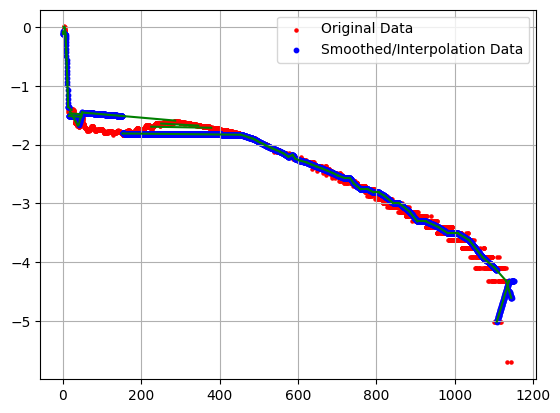

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


== Section = 0 Slope = -0.005972052257940393 ==
== Section = 344 Slope = -0.003622903652622313 ==
== Section = 688 Slope = -6.847978108638452e-05 ==
== Section = 1032 Slope = -8.009828923792637e-05 ==
== Section = 1376 Slope = -0.003117290926707541 ==
== Section = 1720 Slope = -0.002610498518032548 ==
== Section = 2064 Slope = -0.0032635172221215925 ==
== Section = 2408 Slope = -0.004613606893080171 ==
== Section = 2752 Slope = -0.0026463003433543613 ==
== Section = 3096 Slope = -0.010085662884806652 ==
== Section = 3440 Slope = 0.0 ==
[-0.005972052257940393, -0.003622903652622313, -6.847978108638452e-05, -8.009828923792637e-05, -0.003117290926707541, -0.002610498518032548, -0.0032635172221215925, -0.004613606893080171, -0.0026463003433543613, -0.010085662884806652, 0.0]


/var/folders/zp/l_q34h_n52l2xhrxhzs8zz1w0000gn/T/ipykernel_11062/3701488516.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = lst[i] / lst[i+1]  # Calculate the ratio of the current element to the next element


-0.0014690918787660999

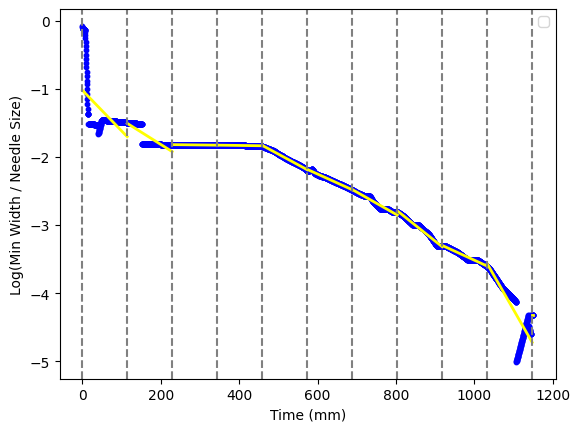

In [45]:
def find_appropriate_slope(numbers):
    if len(numbers) < 3: return None
    numbers.sort()
    min_difference = float('inf')
    most_similar_numbers = []
    for i in range(len(numbers) - 2):
        difference = abs(numbers[i + 2] - numbers[i])
        if difference < min_difference:
            min_difference = difference
            most_similar_numbers = [numbers[i], numbers[i + 1], numbers[i + 2]]
        elif difference == min_difference:
            most_similar_numbers.extend([numbers[i], numbers[i + 1], numbers[i + 2]])
    print(most_similar_numbers)
    return sum(most_similar_numbers) / len(most_similar_numbers)

def findSlope(lst):
    slope = []  # Initialize an empty list to store pairs of values that meet the ratio condition

    # Loop through the list up to the second-to-last element
    for i in range(len(lst) - 1):
        ratio = lst[i] / lst[i+1]  # Calculate the ratio of the current element to the next element
        # print(f"{lst[i]}/{lst[i+1]} = {ratio}")

        # Check if the ratio is within the range [0.8, 1.2]
        if 1.2 >= ratio >= 0.8:
            slope.append(lst[i])  # Append the current element to the slope list
            slope.append(lst[i+1])  # Append the next element to the slope list
    
    # Calculate the average of the values that met the ratio condition
    return sum(slope) / len(slope)
    

def autoRegressor(df):
    df = linspaceSmoother(df)
    x = df["Times"]
    y = df["Width"]
    slopes = []
    intercepts = []
    window_size = len(x)//10

    for section_start in range(0, len(x), window_size):
        end = section_start + window_size
        group_x = x[section_start:end].values.reshape(-1, 1)
        group_y = y[section_start:end]
        lr = LinearRegression()
        lr.fit(group_x, group_y)
        y_pred = lr.predict(group_x)
        slopes.append(lr.coef_[0])
        intercepts.append(lr.intercept_)

        print(f"== Section = {section_start} "
              f"Slope = {lr.coef_[0]} ==")

        mat.scatter(group_x, group_y, color='blue', s=10)
        mat.plot(group_x, y_pred, color='yellow', linewidth=2)
        mat.axvline(x=group_x[0], color='gray', linestyle='--')

    mat.xlabel("Time (mm)")
    mat.ylabel("Log(Min Width / Needle Size)")
    mat.legend()
    print(slopes)
    slopes = list(filter(lambda x: x != 0, slopes))

    return findSlope(slopes)
autoRegressor(data)

,Width,Times,Diff
599,-2.995732,200.066689,NaN
600,-2.995732,200.233411,0.000000
601,-2.995732,200.400133,0.000000
602,-2.995732,200.566856,0.000000
603,-2.995732,200.733578,0.000000
...,...,...,...
1494,-4.734549,478.659553,-0.003379
1495,-4.740325,478.992998,-0.005776
1496,-4.743704,479.326442,-0.003379
1497,-4.752859,479.659887,-0.009155


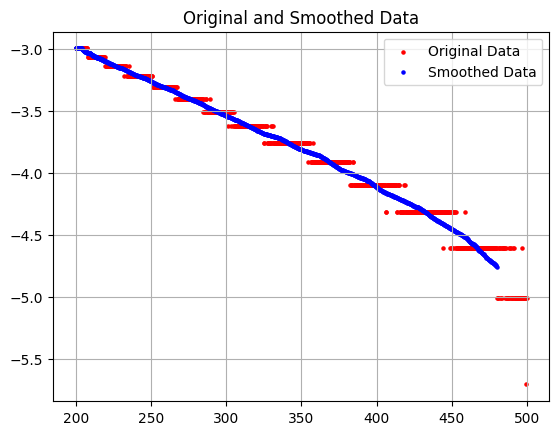

In [21]:
def apply_savitzky(dataframe, window_length=80, polyorder=1):
    df = dataframe.copy()

    smoothed_width = savgol_filter(df["Width"], window_length, polyorder)
    df["Smoothed_Width"] = smoothed_width

    mat.scatter(df["Times"], df["Width"], label="Original Width", marker="o")
    mat.plot(df["Times"], df["Smoothed_Width"], label="Smoothed Width", linestyle="-", color="red")
    mat.grid()
    mat.title("Savitzky-Golay Smoothing")
    mat.show()
    return df


def average(dataframe, window_size=120):
    smoothed_data = dataframe.rolling(window=window_size, min_periods=1).mean()

    mat.scatter(dataframe["Times"], dataframe["Width"], label='Original Data', s=5, c='red')
    mat.scatter(smoothed_data["Times"], smoothed_data["Width"], label=f'Smoothed Data', s=5, c="blue")
    mat.legend()
    mat.title('Original and Smoothed Data')
    mat.grid(True)
    return smoothed_data

average(data)
# apply_savitzky(data)